# Table detection with `OPENCV_CONTOURS`

:::{warning}
This is an *experimental*, alternate method for table detection. The method is promising, but it has some rough edges which
needs to be fixed before it can be used.
:::

The algorithm behind this method can be approximately described as follows:

- We start from a grayscale pre-processed image with textremoved and tables identified using {func}`scipy.ndimage.label` as in [](./table_detect_scipy_proj.myst.ipynb).
- The function {func}`dawsonia.table_detect.opencv_contours.get_table_structure` calls `cv2.findContours` to identify contours. The bounding boxes (bbox) are saved instead of the exact curvilinear contour. Unusual bboxes (too small, too big, strange aspect ratios) are weeded out,
- Clustering algorithm {func}`dawsonia.table_detect.opencv_contours.cluster_axis` identifies columns and rows
- Column clusters and row clusters are intersected to form a 3D array, with shape `(nb_rows, nb_columns, 4)` in {func}`dawsonia.table_detect.opencv_contours.create_bbox_array`.
- Once again unusual bboxes (width or height deviates too much from the median in the column / row) are removed using {func}`dawsonia.table_detect.opencv_contours.set_nan_to_odd_bboxes`.
- Missing bboxes are discovered using a cubic curve fit in {func}`dawsonia.table_detect.opencv_contours.fix_missing_bboxes`. 

To activate this the table configuration file need to be altered. But first, we start by setting our environment

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
autoreload 2

In [4]:
import os
os.environ["DAWSONIA_DEBUG_TABLE_DETECT"] = "1"

Now we write a new _table formats_ file. Notice the new key `method` under `[default.preproc]`.

In [5]:
%%file table_formats/bjuröklubb_example.toml
[default]
version = 0

# Default values, but wrote explicitly here. See PreprocConfig class
[default.preproc]
table_modif = true
corr_rotate = true
## NOTE: Here we alter the method
method = "OPENCV_CONTOURS"
row_idx_unit = "HOURS"
idx_tables_size_verify = [0, 1]

[1927]
version = 1

[version.0]
columns = [
  [
    "term_på_baro",
    "barom",
    "torra_term",
    "våta_term",
    "moln_slag_lägre",
    "moln_mängd_lägre",
    "moln_slag_medel",
    "moln_slag_högre"
  ],
  [
    "moln_het_sol_dimma_nederbörd_total",
    "vind_riktning",
    "vind_beaufort",
    "vind_m_sek",
    "sikt",
    "sjögang",
    "maximi_term",
    "minimi_term",
    "nederbörd_mängd",
    "nederbörd_slag"
  ]
]
name_idx = "tid"
rows = [2, 8, 14, 19, 21]
tables = [
  [5, 8],
  [5, 10],
  [3, 1],
  [4, 2],
  [4, 5]
]

[version.1]
columns = [
  [
    "term_på_baro",
    "barom",
    "torra_term",
    "våta_term",
    "moln_slag_lägre",
    "moln_mängd_lägre",
    "moln_slag_högre",
    "moln_mängd_total"
  ],
  [
    "vind_riktning",
    "vind_beaufort",
    "vind_m_sek",
    "sikt",
    "sjögang",
    "maximi_term",
    "minimi_term",
    "nederbörd_mängd",
    "nederbörd_slag"
  ]
]
rows = [2, 8, 14, 19, 21]
tables = [
  [5, 8],
  [5, 9],
  [3, 1],
  [4, 2],
  [4, 5]
]

Overwriting table_formats/bjuröklubb_example.toml


## Demo: Table detection

Now that we have all the prerequisites read, let's execute the command:

```sh
DAWSONIA_DEBUG_TABLE_DETECT=1 dawsonia label --first-page 4 --last-page 4 --no-interactive data/raw_zarr/bjuröklubb_example/bjuröklubb_1927.zarr
```

or its Python API equivalent:

INFO     2024-06-02 22:02:14,892 - dawsonia.io._zarr - INFO - table_format = TableFormat(name_idx='tid',           
         columns=[['term_på_baro', 'barom', 'torra_term', 'våta_term', 'moln_slag_lägre', 'moln_mängd_lägre',      
         'moln_slag_högre', 'moln_mängd_total'], ['vind_riktning', 'vind_beaufort', 'vind_m_sek', 'sikt',          
         'sjögang', 'maximi_term', 'minimi_term', 'nederbörd_mängd', 'nederbörd_slag']], rows=(datetime.time(2, 0),
         datetime.time(8, 0), datetime.time(14, 0), datetime.time(19, 0), datetime.time(21, 0)), tables=[[5, 8],   
         [5, 9], [3, 1], [4, 2], [4, 5]], preproc=PreprocConfig(table_modif=True, corr_rotate=True,                
         row_idx_unit=<TimeUnits.HOURS: 1>, method=<PreprocMethods.OPENCV_CONTOURS: 2>, idx_tables_size_verify=[0, 
         1]), transforms=None, version='1', station='bjuröklubb_example')

INFO     2024-06-02 22:02:14,913 - dawsonia.io._zarr - INFO - Setting first_page = 4

INFO     2024-06-02 22:02:14,919 - dawsonia.io._zarr - INFO - Setting first_page = 4

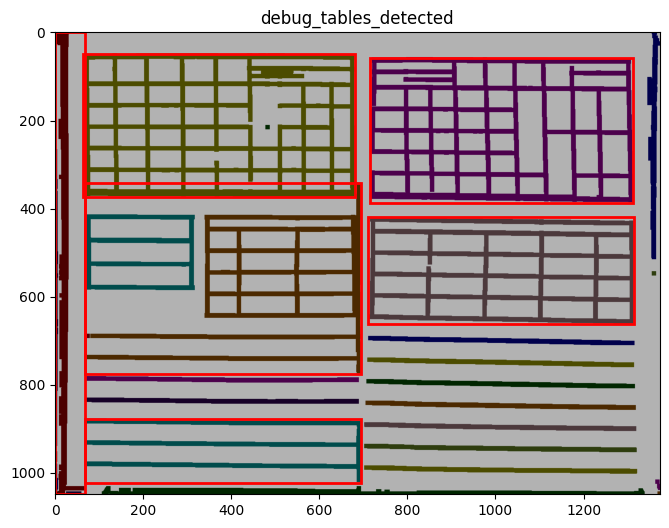

INFO     2024-06-02 22:02:21,643 - dawsonia.table_detect.opencv_contours - INFO - Finding contours for a mask with 
         table_nb_pixels=19366

INFO     2024-06-02 22:02:21,655 - dawsonia.table_detect.opencv_contours - INFO - No bboxes detected!

INFO     2024-06-02 22:02:21,678 - dawsonia.table_detect.opencv_contours - INFO - Finding contours for a mask with 
         table_nb_pixels=75059

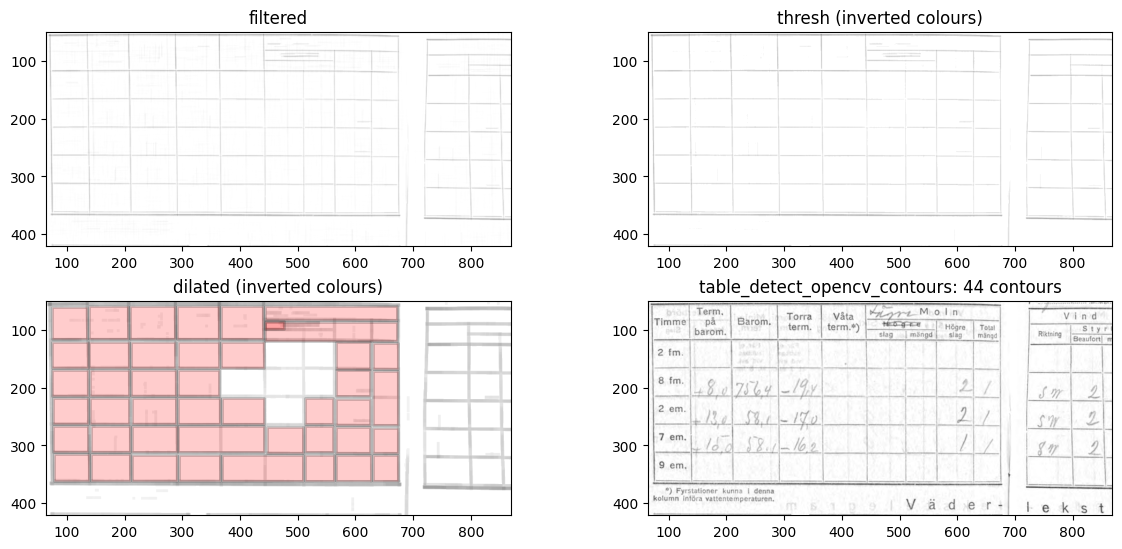

INFO     2024-06-02 22:02:23,325 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [ 3  1  4  5  9 
         6 10  2  0  7  8]

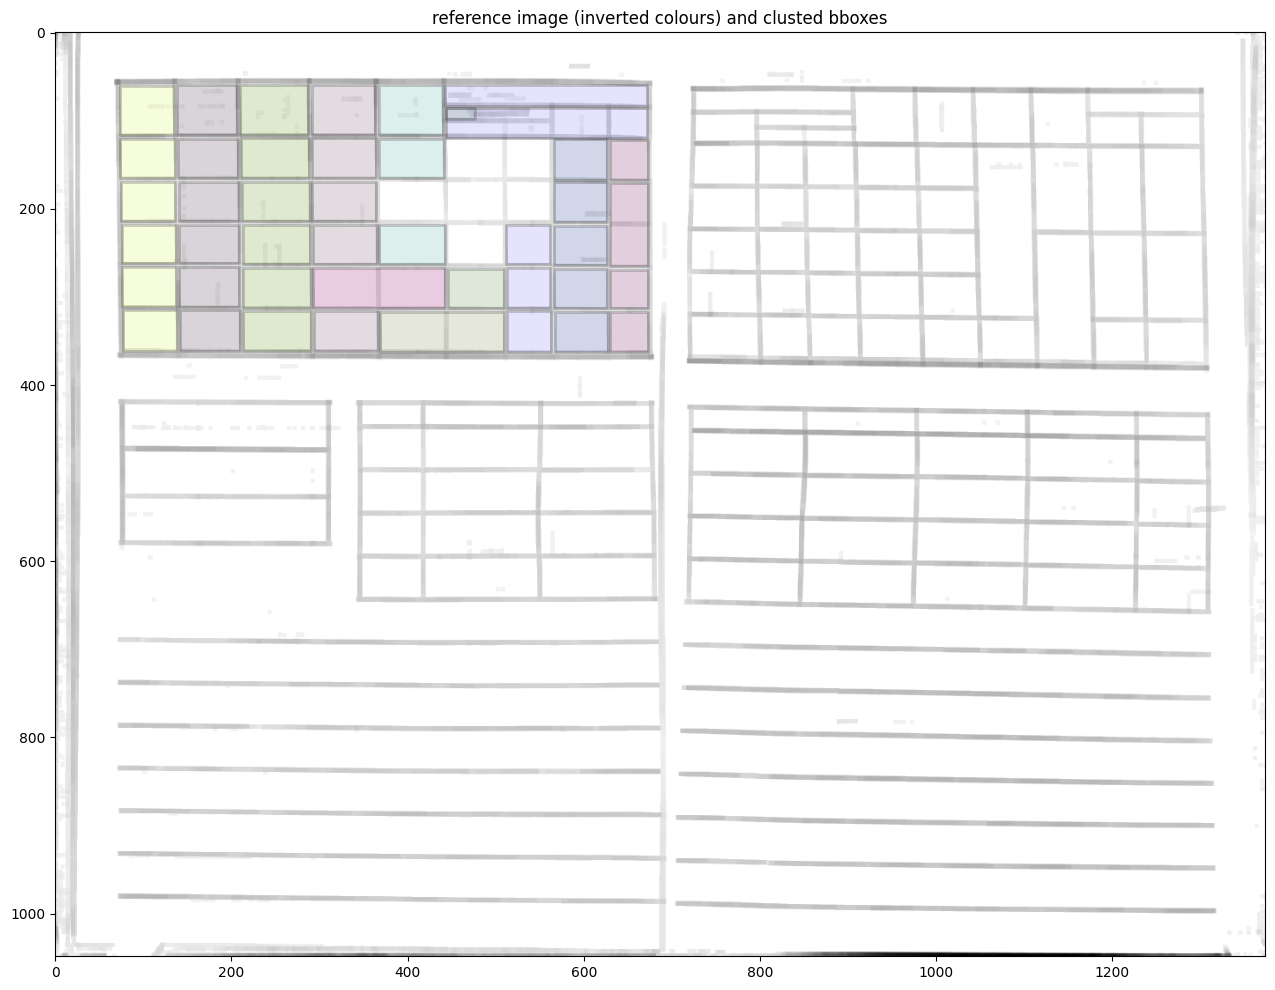

INFO     2024-06-02 22:02:24,159 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [6 0 1 5 7 3 2  
         4]

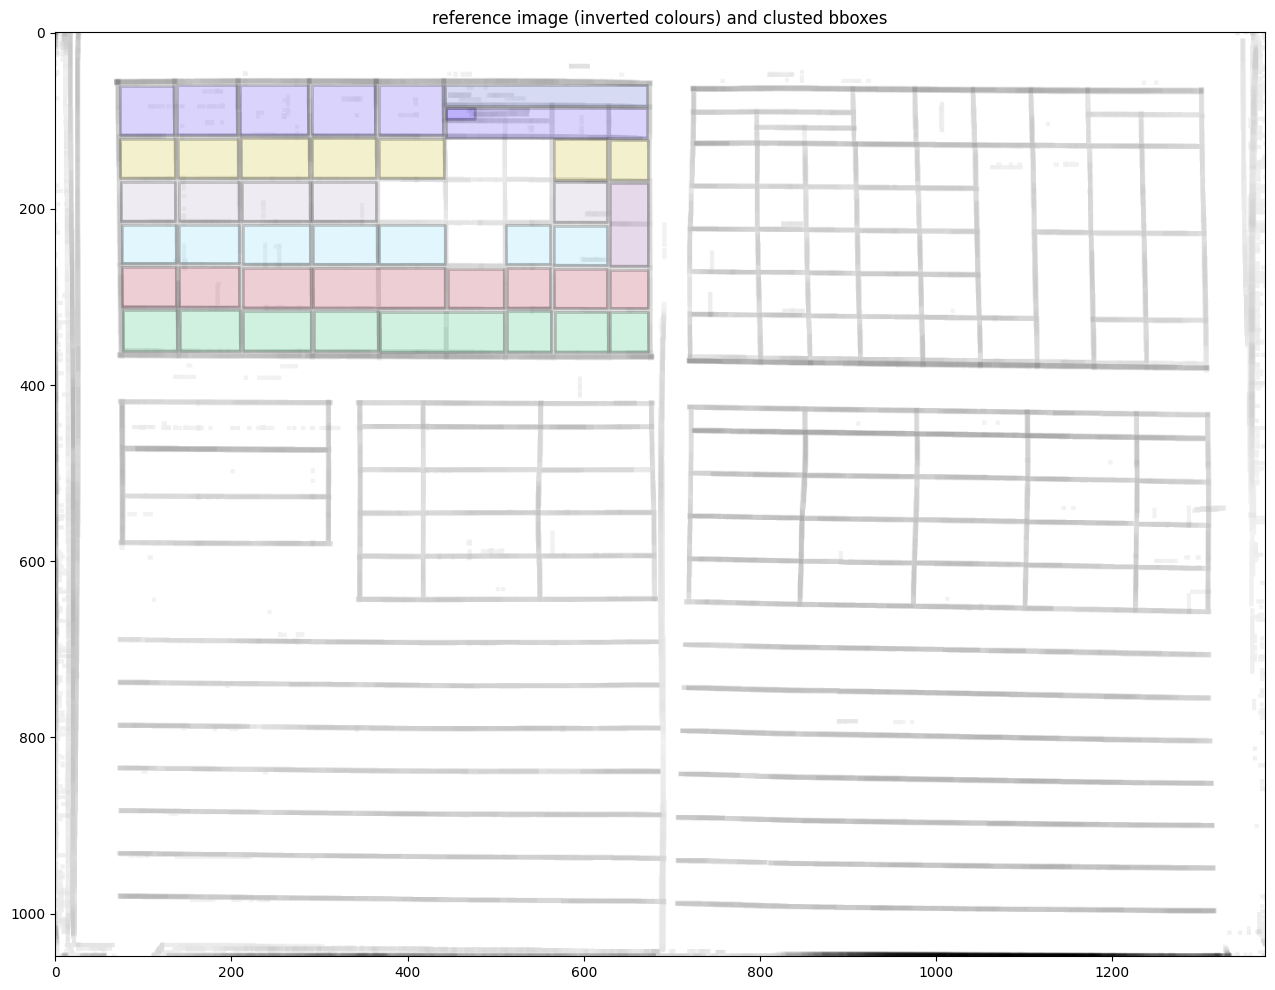

/home/a002487/.pyenv/versions/3.9.13/envs/ai-for-obs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


INFO     2024-06-02 22:02:25,039 - dawsonia.table_detect.opencv_contours - INFO - Dumped ('bboxes',                
         'column_labels', 'column_bboxes_idxs', 'row_labels', 'row_bboxes_idxs', 'original_image') into            
         /home/a002487/Sources/ai-for-obs/dawsonia/docs/source/getting_started/get_table_structure_07ca022c-211b-11
         ef-98fa-84c5a6cd0398.joblib. Explore it using get_table_strucutre_interpolation.ipynb

INFO     2024-06-02 22:02:25,055 - dawsonia.table_detect.opencv_contours - INFO - Finding contours for a mask with 
         table_nb_pixels=70550

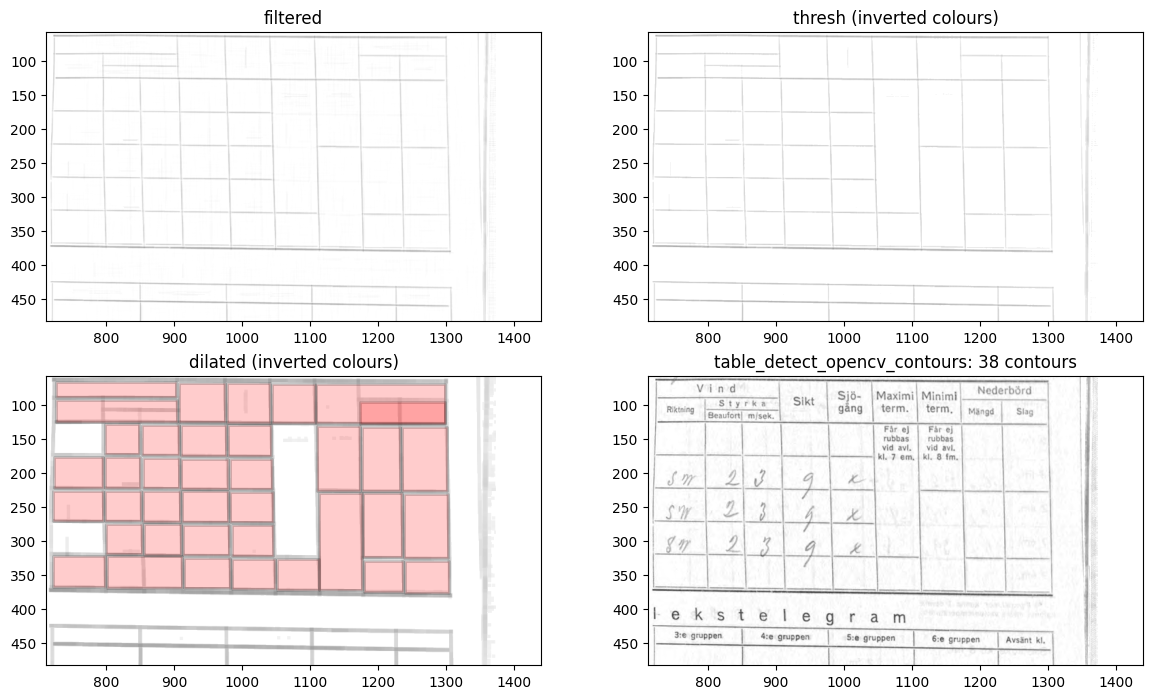

INFO     2024-06-02 22:02:26,971 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [ 8  0 10  5  1 
         2  4  6  3  9  7]

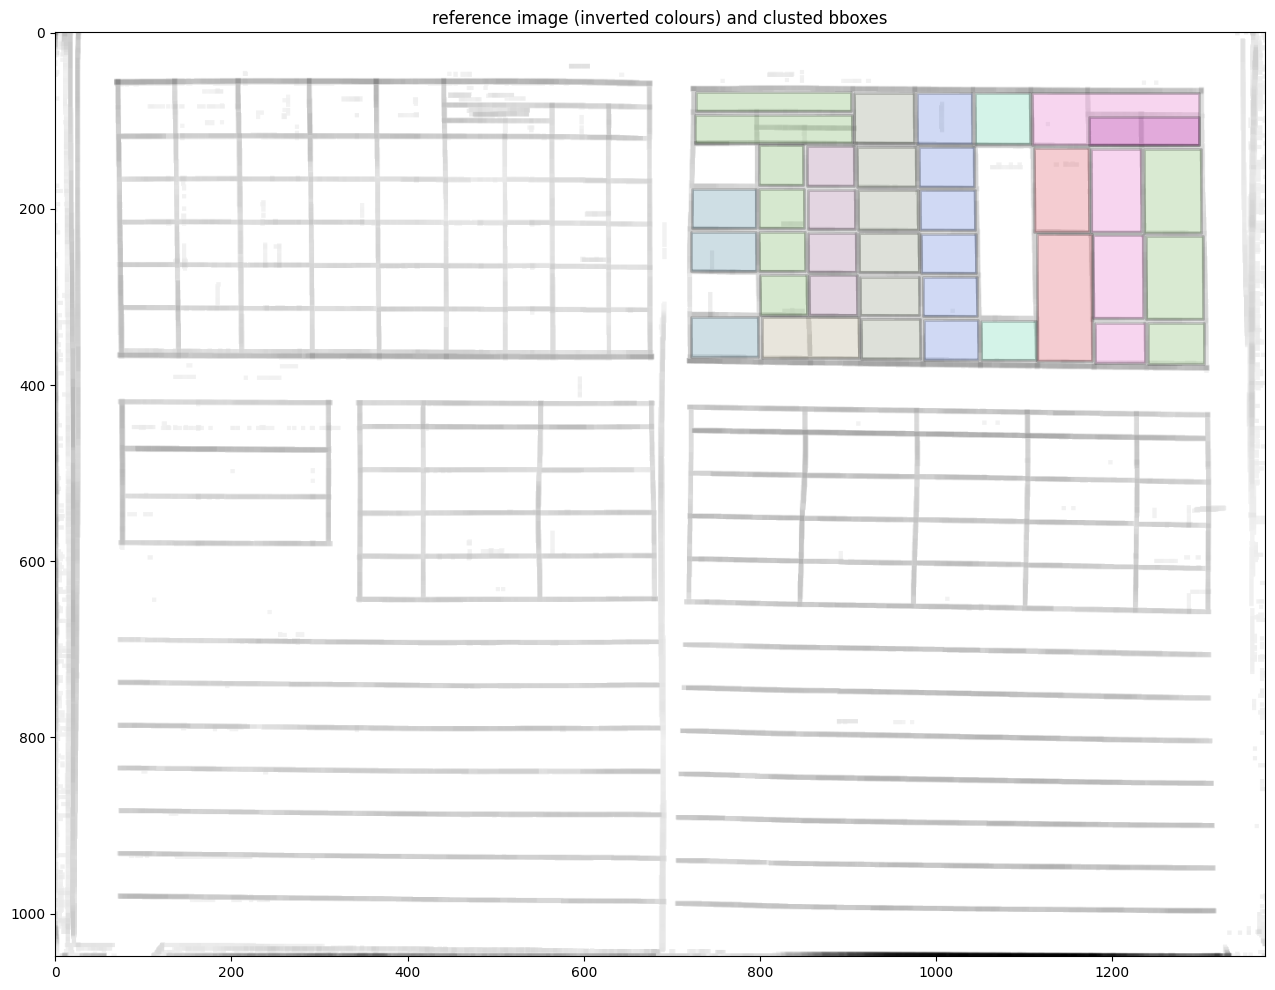

INFO     2024-06-02 22:02:27,894 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [6 0 5 8 3 4 7 2
         1]

/home/a002487/.pyenv/versions/3.9.13/envs/ai-for-obs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


INFO     2024-06-02 22:02:28,921 - dawsonia.table_detect.opencv_contours - INFO - Dumped ('bboxes',                
         'column_labels', 'column_bboxes_idxs', 'row_labels', 'row_bboxes_idxs', 'original_image') into            
         /home/a002487/Sources/ai-for-obs/dawsonia/docs/source/getting_started/get_table_structure_0a1a75fc-211b-11
         ef-98fa-84c5a6cd0398.joblib. Explore it using get_table_strucutre_interpolation.ipynb

INFO     2024-06-02 22:02:28,955 - dawsonia.table_detect.opencv_contours - INFO - Finding contours for a mask with 
         table_nb_pixels=46857

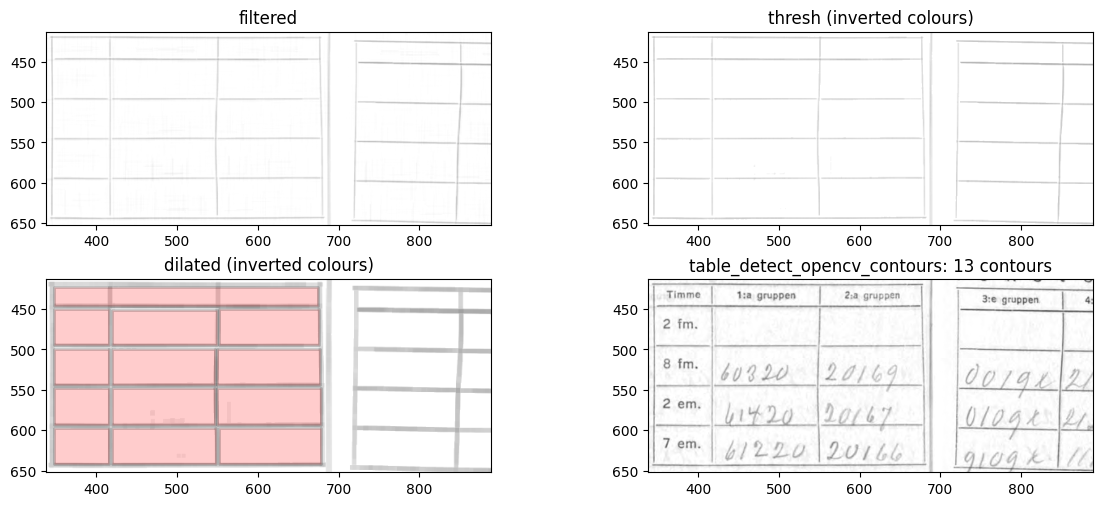

INFO     2024-06-02 22:02:30,577 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [2 3 1 0]

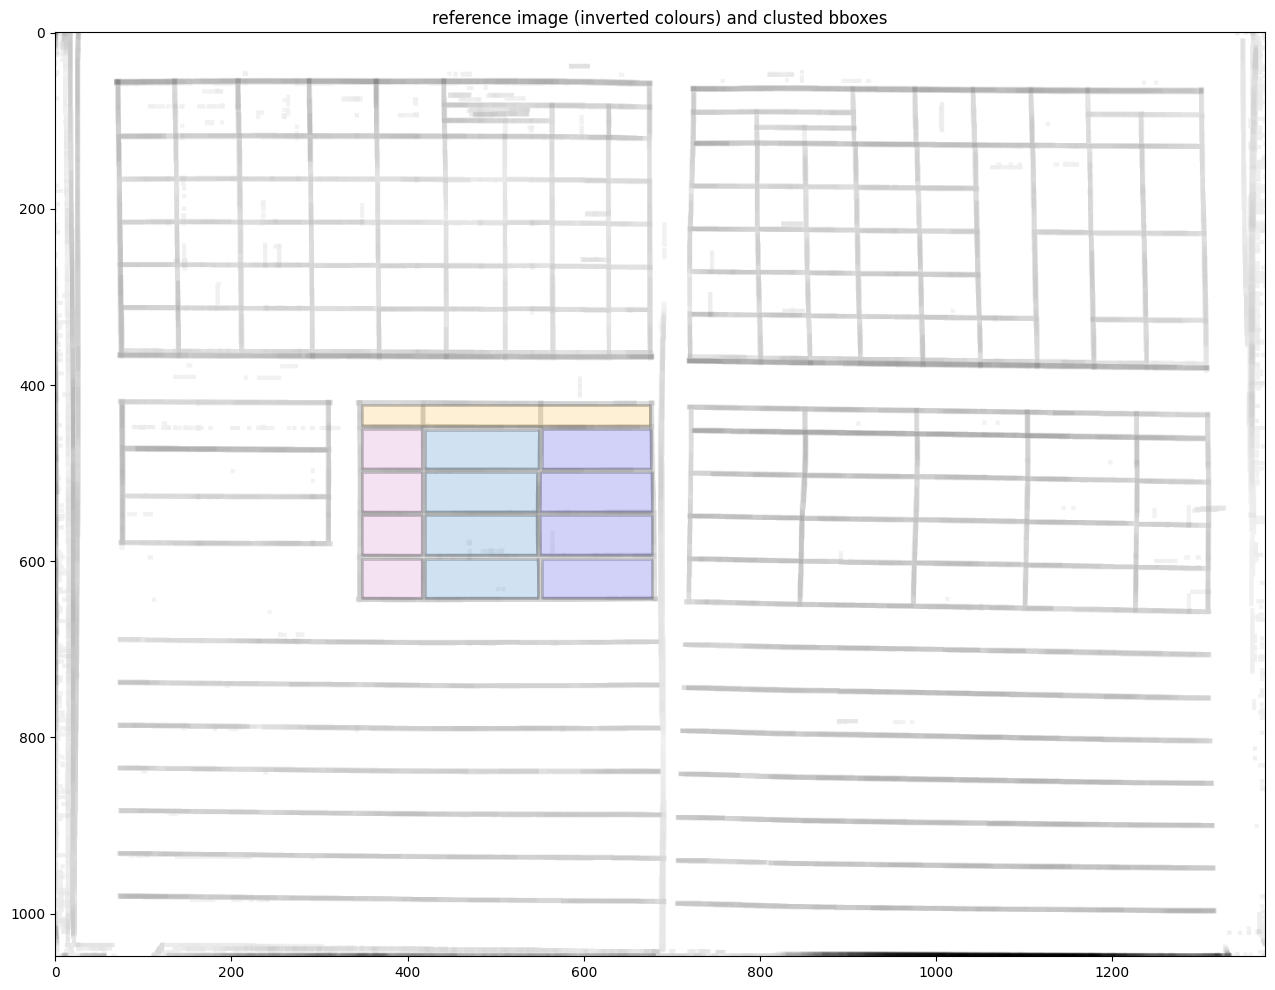

INFO     2024-06-02 22:02:31,400 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [4 0 2 1 3]

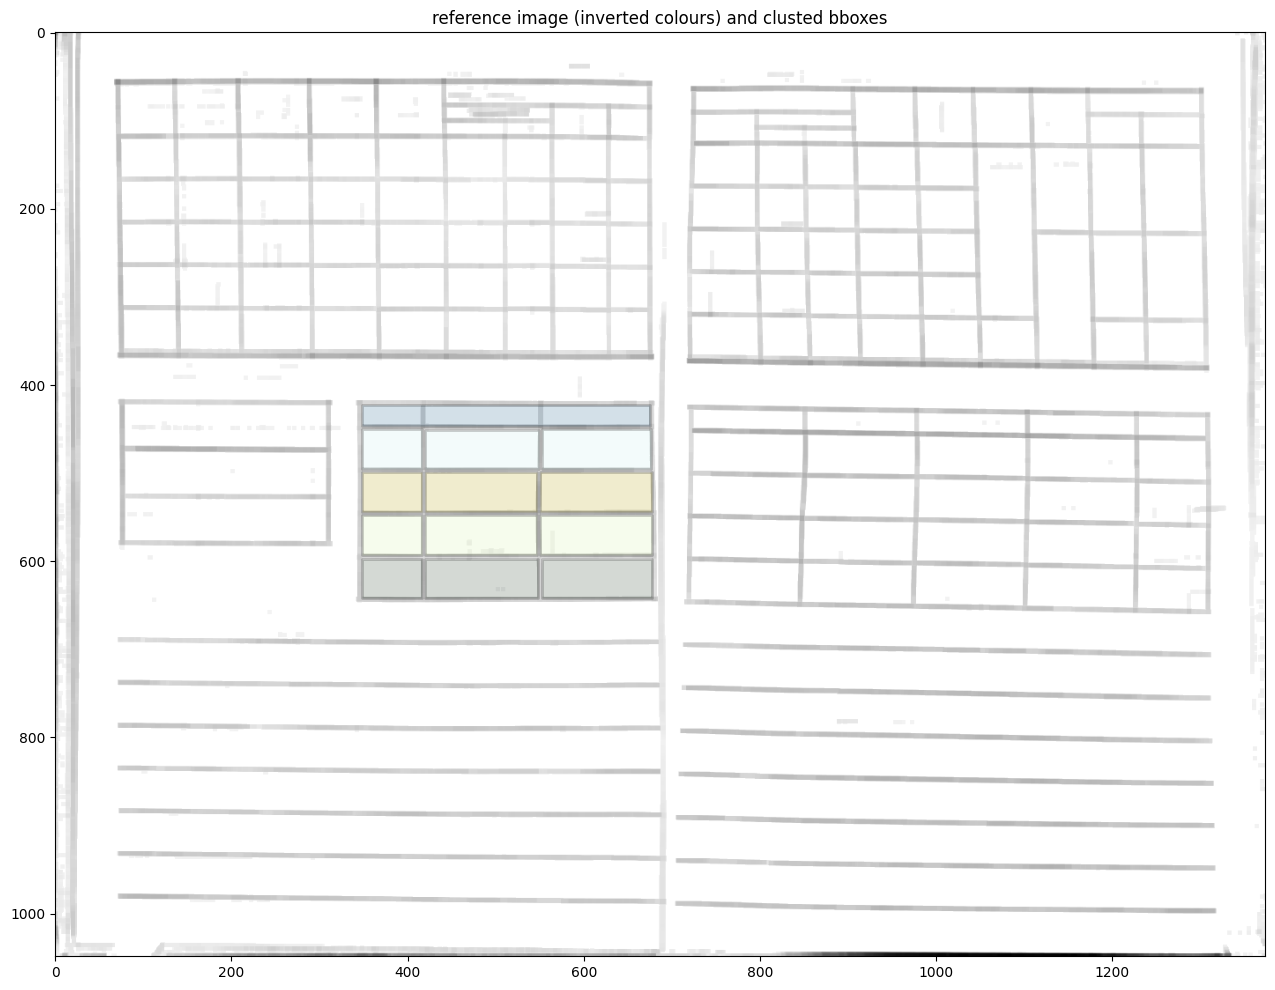

ERROR    2024-06-02 22:02:32,228 - dawsonia.table_detect.opencv_contours - ERROR - Error occured while attempting  
         to curve fit with 3 data points. Defaulting to median value...

ERROR    2024-06-02 22:02:32,235 - dawsonia.table_detect.opencv_contours - ERROR - TypeError('The number of func   
         parameters=4 must not exceed the number of data points=3')

INFO     2024-06-02 22:02:32,249 - dawsonia.table_detect.opencv_contours - INFO - Dumped ('bboxes',                
         'column_labels', 'column_bboxes_idxs', 'row_labels', 'row_bboxes_idxs', 'original_image') into            
         /home/a002487/Sources/ai-for-obs/dawsonia/docs/source/getting_started/get_table_structure_0c168e22-211b-11
         ef-98fa-84c5a6cd0398.joblib. Explore it using get_table_strucutre_interpolation.ipynb

INFO     2024-06-02 22:02:32,272 - dawsonia.table_detect.opencv_contours - INFO - Finding contours for a mask with 
         table_nb_pixels=49994

INFO     2024-06-02 22:02:33,575 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [2 0 1 3 4]

INFO     2024-06-02 22:02:34,751 - dawsonia.table_detect.opencv_contours - INFO - cluster labels = [1 3 2 0]

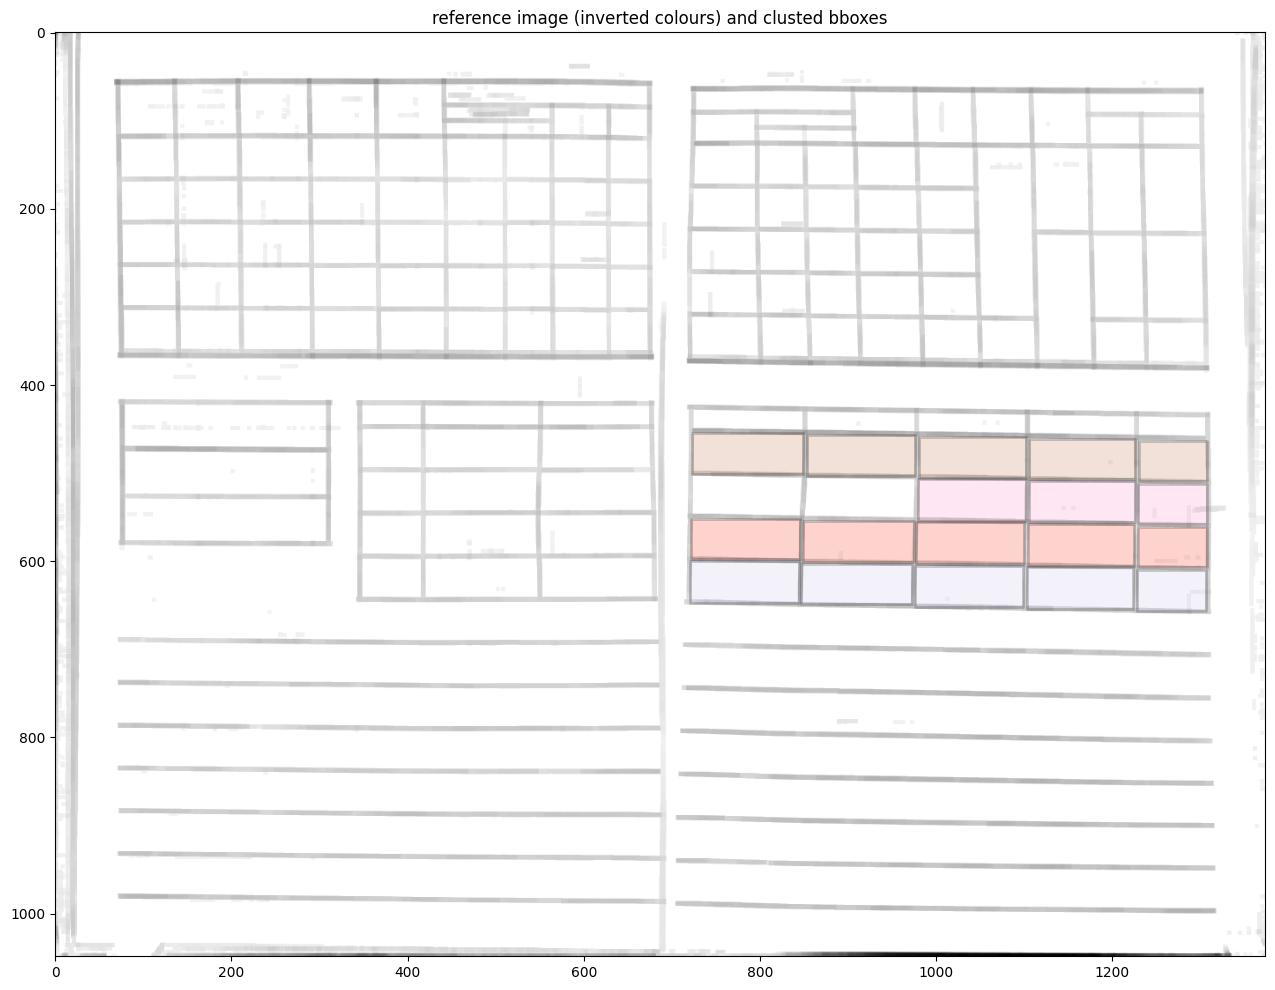

INFO     2024-06-02 22:02:35,810 - dawsonia.table_detect.opencv_contours - INFO - Dumped ('bboxes',                
         'column_labels', 'column_bboxes_idxs', 'row_labels', 'row_bboxes_idxs', 'original_image') into            
         /home/a002487/Sources/ai-for-obs/dawsonia/docs/source/getting_started/get_table_structure_0e35f5c6-211b-11
         ef-98fa-84c5a6cd0398.joblib. Explore it using get_table_strucutre_interpolation.ipynb

INFO     2024-06-02 22:02:35,895 - dawsonia.table_detect.opencv_contours - INFO - Finding contours for a mask with 
         table_nb_pixels=21511

INFO     2024-06-02 22:02:35,909 - dawsonia.table_detect.opencv_contours - INFO - No bboxes detected!

INFO     2024-06-02 22:02:35,998 - dawsonia.table_detect.opencv_contours - INFO - Preproc: applying                
         table_modif_rm_row_col

INFO     2024-06-02 22:02:36,003 - dawsonia.table_detect.utils - INFO - 🌧 no tables found

INFO     2024-06-02 22:02:36,015 - dawsonia.label - INFO - Table 0 not detected

INFO     2024-06-02 22:02:36,021 - dawsonia.label - INFO - Table 1 not detected

INFO     2024-06-02 22:02:36,027 - dawsonia.label - INFO - Table 2 not detected

INFO     2024-06-02 22:02:36,033 - dawsonia.label - INFO - Table 3 not detected

INFO     2024-06-02 22:02:36,039 - dawsonia.label - INFO - Table 4 not detected

In [6]:
from dawsonia import label

label.command("data/raw_zarr/bjuröklubb_example/bjuröklubb_1927.zarr", 4, 4, interactive=False)